In [4]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import os
import numpy as np
import pandas as pd

In [12]:
dataset_path = "/kaggle/input/my-fish-dataset/mydataset"  # Replace with your actual path

# Initialize lists to store file paths and class names
file_paths = []
classes = []

# Loop through each folder (class) and each file within it
for class_name in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_folder):
        for filename in os.listdir(class_folder):
            file_paths.append(os.path.join(class_folder, filename))
            classes.append(class_name)

# Create the DataFrame
df = pd.DataFrame({'file_path': file_paths, 'class': classes})

# Display the DataFrame
print(df.sample(n=10, random_state=1))

                                              file_path  \
6487  /kaggle/input/my-fish-dataset/mydataset/Clown ...   
599   /kaggle/input/my-fish-dataset/mydataset/Yellow...   
5907  /kaggle/input/my-fish-dataset/mydataset/Clown ...   
3260  /kaggle/input/my-fish-dataset/mydataset/Betta ...   
6276  /kaggle/input/my-fish-dataset/mydataset/Clown ...   
4203  /kaggle/input/my-fish-dataset/mydataset/Blue t...   
2025  /kaggle/input/my-fish-dataset/mydataset/Archer...   
6844  /kaggle/input/my-fish-dataset/mydataset/Clown ...   
3842  /kaggle/input/my-fish-dataset/mydataset/Betta ...   
2241  /kaggle/input/my-fish-dataset/mydataset/Archer...   

                         class  
6487  Clown Sword Trigger Fish  
599                Yellow Tang  
5907  Clown Sword Trigger Fish  
3260                Betta Fish  
6276  Clown Sword Trigger Fish  
4203                 Blue tang  
2025               Archer Fish  
6844  Clown Sword Trigger Fish  
3842                Betta Fish  
2241               A

In [13]:
from sklearn.model_selection import train_test_split

# First, split into train+val and test
train_val_df, test_df = train_test_split(df, test_size=0.15, stratify=df['class'], random_state=1)

# Then split train+val into train and val
train_df, val_df = train_test_split(train_val_df, test_size=0.25, stratify=train_val_df['class'], random_state=1)

# Print the number of instances in each set
print(f"Training set: {len(train_df)}")
print(f"Validation set: {len(val_df)}")
print(f"Test set: {len(test_df)}")

Training set: 4401
Validation set: 1468
Test set: 1036


In [6]:
# Define paths to the dataset directories
train_dir = '/kaggle/input/my-dataset/mydataset_split/train'
val_dir = '/kaggle/input/my-dataset/mydataset_split/val'
test_dir = '/kaggle/input/my-dataset/mydataset_split/test'


In [7]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/my-dataset/mydataset_split/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    '/kaggle/input/my-dataset/mydataset_split/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = val_datagen.flow_from_directory(
    '/kaggle/input/my-dataset/mydataset_split/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 4943 images belonging to 5 classes.
Found 1430 images belonging to 5 classes.
Found 692 images belonging to 5 classes.


In [14]:
import tensorflow as tf

# Define the ImageDataGenerators with augmentation for training
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Create the data generators using flow_from_dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',  # Column in the dataframe containing file paths
    y_col='class',      # Column in the dataframe containing class labels
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='file_path',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Typically, we don't shuffle the test set
)

Found 4401 validated image filenames belonging to 5 classes.
Found 1468 validated image filenames belonging to 5 classes.
Found 1036 validated image filenames belonging to 5 classes.


In [16]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# Load ResNet50 with pre-trained ImageNet weights, excluding the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Adding Dense Layers with Batch Normalization and Dropout
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output layer with softmax for a 5-class classification
predictions = Dense(5, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Display the model summary
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,147,333 (92.11 MB)

 Trainable params: 558,853 (2.13 MB)

 Non-trainable params: 23,588,480 (89.98 MB)

In [14]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)

# Adding Dense Layers with Batch Normalization and Dropout
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output layer with softmax
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


In [17]:
# Learning rate scheduling
optimizer = Adam(learning_rate=1e-4)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [18]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

callbacks = [early_stop, checkpoint, reduce_lr]


In [19]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=callbacks
)


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731159636.202609     201 service.cc:145] XLA service 0x7b64740028c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731159636.202669     201 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/138 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.2188 - loss: 3.5306  

I0000 00:00:1731159644.362314     201 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


138/138 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.2823 - loss: 2.8573 - val_accuracy: 0.2159 - val_loss: 2.0920 - learning_rate: 1.0000e-04
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 120s 833ms/step - accuracy: 0.4575 - loss: 1.9703 - val_accuracy: 0.3896 - val_loss: 1.6404 - learning_rate: 1.0000e-04
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 119s 821ms/step - accuracy: 0.4981 - loss: 1.7220 - val_accuracy: 0.6322 - val_loss: 1.2516 - learning_rate: 1.0000e-04
Epoch 4/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 116s 800ms/step - accuracy: 0.5389 - loss: 1.5432 - val_accuracy: 0.7010 - val_loss: 1.0802 - learning_rate: 1.0000e-04
Epoch 5/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 140s 791ms/step - accuracy: 0.5994 - loss: 1.3655 - val_accuracy: 0.6226 - val_loss: 1.1749 - learning_rate: 1.0000e-04
Epoch 6/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 117s 813ms/step - accuracy: 0.6031 - loss: 1.3390 - val_accuracy: 0.6914 - val_loss: 1.0536 - learning_rate: 1.0000e-04
Epoch 7/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 114s 789ms/ste

In [20]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 645ms/step - accuracy: 0.8784 - loss: 0.4762
Test Accuracy: 0.8851
Test Loss: 0.4717


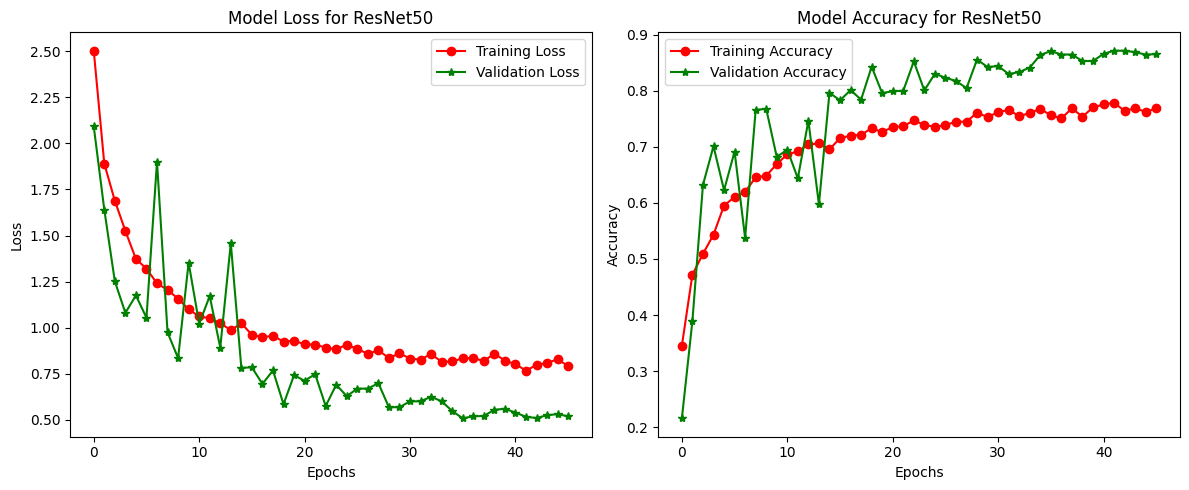

In [21]:
from matplotlib import pyplot as plt

# Create the plot
plt.figure(figsize=(12, 5))

# Subplot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], color='r', label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], color='g', label='Validation Loss', marker='*')
plt.title('Model Loss for ResNet50')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

# Subplot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], color='r', label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], color='g', label='Validation Accuracy', marker='*')
plt.title('Model Accuracy for ResNet50')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

# Adjust layout
plt.tight_layout()

# Save the plot as an image file
plt.savefig(r"ResNet50_model_performance.png")  # Corrected line

# Display the plot
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


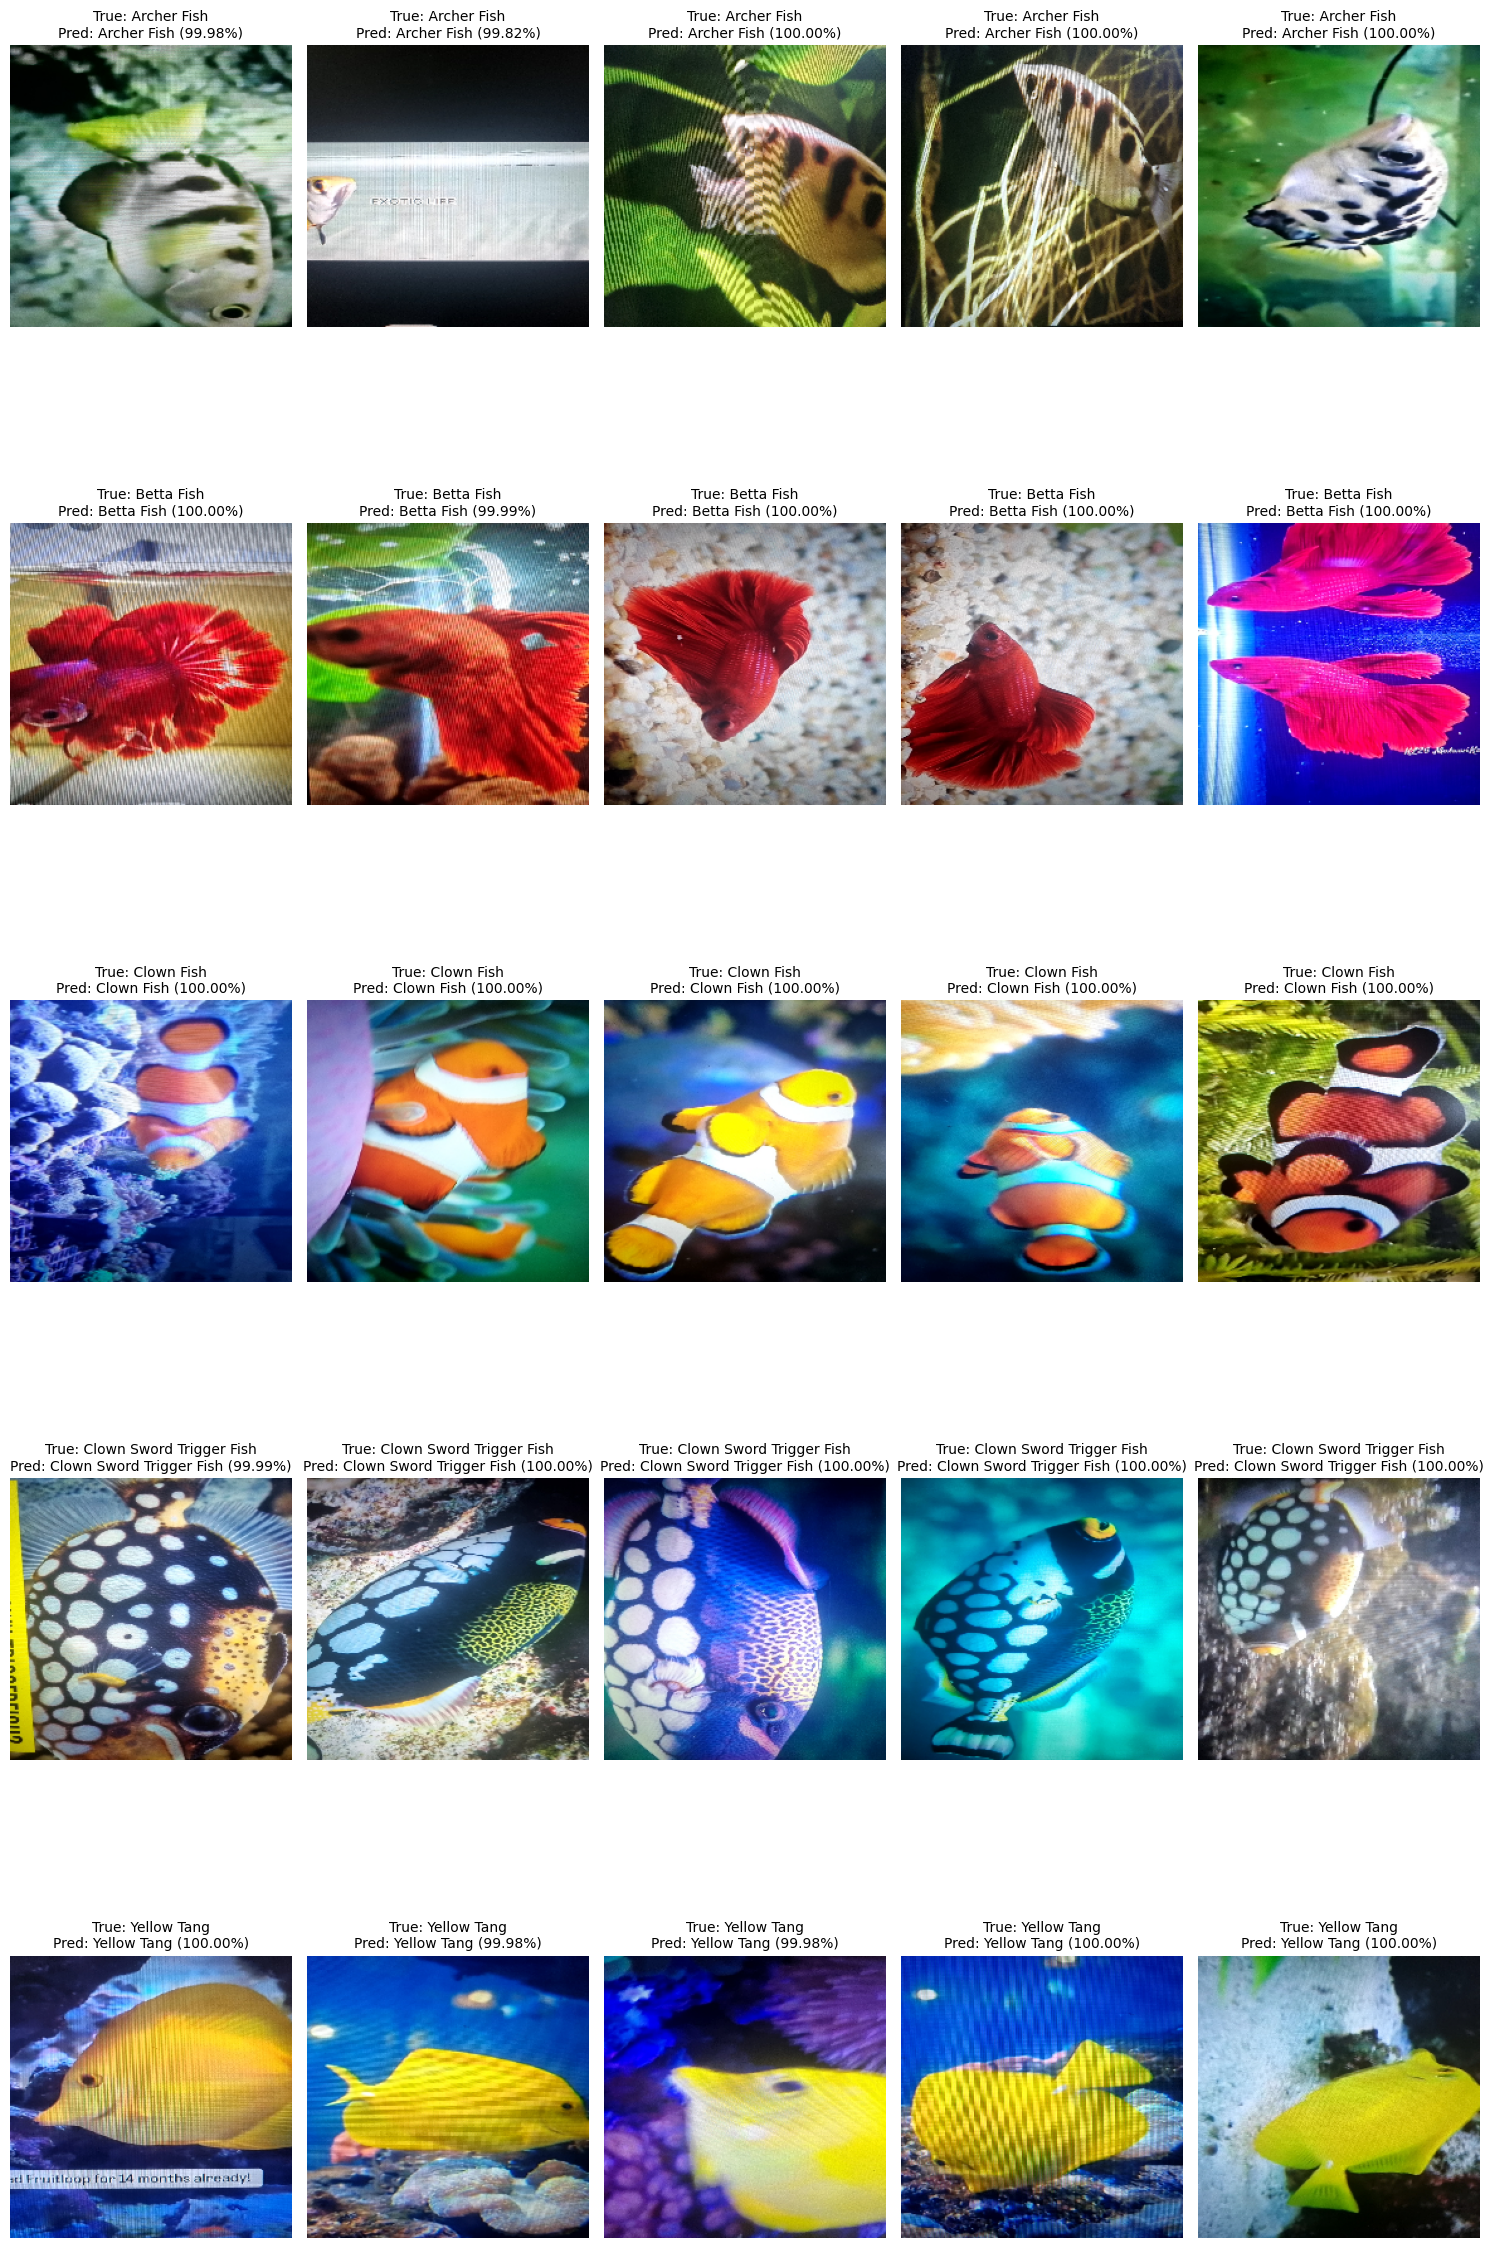

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

# Define a function to plot images with true and predicted labels
def plot_images_with_preds(model, class_names, data_dir, num_images_per_class=5):
    plt.figure(figsize=(15, 25))  # Adjusted figure size for more images
    img_count = 0

    # Loop through each class and randomly select images
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        images = os.listdir(class_dir)
        random_images = random.sample(images, num_images_per_class)

        for img_name in random_images:
            img_path = os.path.join(class_dir, img_name)

            # Load and preprocess the image
            img = load_img(img_path, target_size=(224, 224))  # Resize to match model input
            img_array = img_to_array(img) / 255.0  # Normalize the image
            img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

            # Make predictions
            preds = model.predict(img_array)
            pred_label = np.argmax(preds, axis=1)[0]  # Predicted class index
            confidence = np.max(preds)  # Confidence score
            true_label = class_names.index(class_name)  # True class index

            # Plot the image
            img_count += 1
            plt.subplot(len(class_names), num_images_per_class, img_count)  # Adjusted to fit all images
            plt.imshow(img)
            plt.axis('off')

            # Set the title with true label, predicted label, and confidence score
            plt.title(f"True: {class_name}\nPred: {class_names[pred_label]} ({confidence*100:.2f}%)", fontsize=10)

    plt.tight_layout()
    plt.show()

# Get class names from the directory structure
class_names = sorted(train_generator.class_indices.keys())

# Call the function with the model, class names, and test directory
plot_images_with_preds(model, class_names, test_dir, num_images_per_class=5)


33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 484ms/step


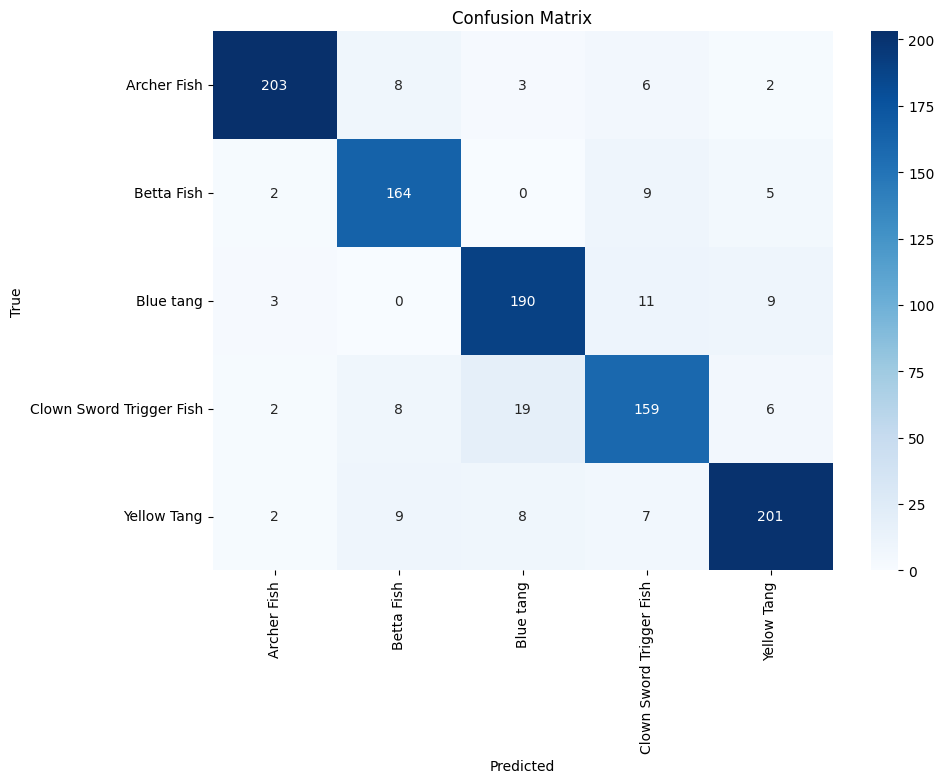

                          precision    recall  f1-score   support

             Archer Fish       0.96      0.91      0.94       222
              Betta Fish       0.87      0.91      0.89       180
               Blue tang       0.86      0.89      0.88       213
Clown Sword Trigger Fish       0.83      0.82      0.82       194
             Yellow Tang       0.90      0.89      0.89       227

                accuracy                           0.89      1036
               macro avg       0.88      0.88      0.88      1036
            weighted avg       0.89      0.89      0.89      1036



In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf

# Step 1: Load the trained model from a specified path
model_path = '/kaggle/working/best_model.keras'  # Replace with your actual model path
model = tf.keras.models.load_model(model_path)

# Step 2: Generate predictions and true labels
y_true = test_generator.classes  # True labels
y_pred_prob = model.predict(test_generator)  # Model predictions (probabilities)
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class indices

# Step 3: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = sorted(train_generator.class_indices.keys())  # Class names

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))


In [22]:
# Get the true labels from the test generator
y_true = test_generator.classes  # This gives you the true labels for your test dataset

# Get the predicted labels from your model
y_pred_prob = model.predict(test_generator)  # Predict probabilities for each class
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 413ms/step


In [27]:
from tensorflow.keras.models import load_model
model = load_model('/kaggle/working/fish_species_classification_model.keras')


In [29]:
test_loss, test_accuracy = model.evaluate(test_generator)


22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 440ms/step - accuracy: 0.9499 - loss: 0.3818


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 390ms/step
                          precision    recall  f1-score   support

             Archer Fish       0.18      0.18      0.18       139
              Betta Fish       0.21      0.21      0.21       158
              Clown Fish       0.18      0.18      0.18       150
Clown Sword Trigger Fish       0.17      0.17      0.17       104
             Yellow Tang       0.16      0.16      0.16       141

                accuracy                           0.18       692
               macro avg       0.18      0.18      0.18       692
            weighted avg       0.18      0.18      0.18       692



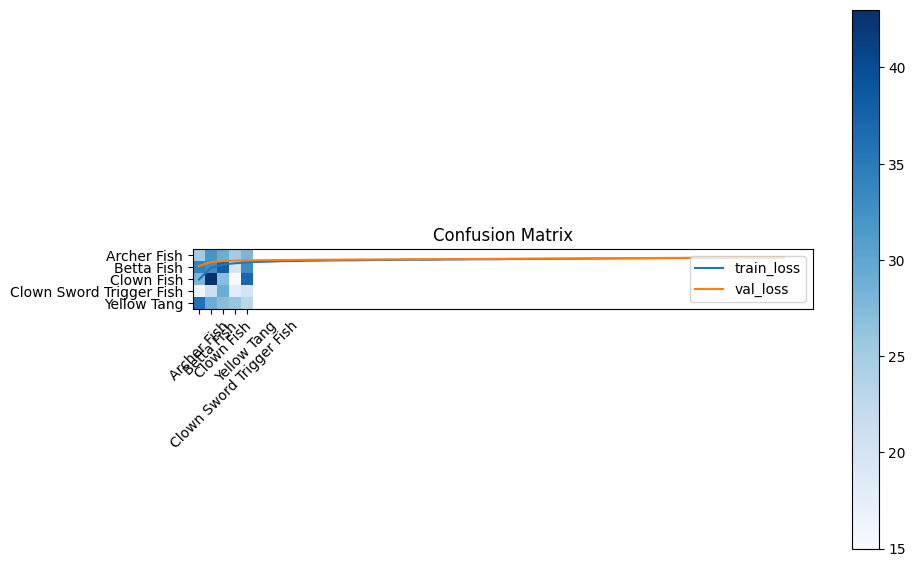

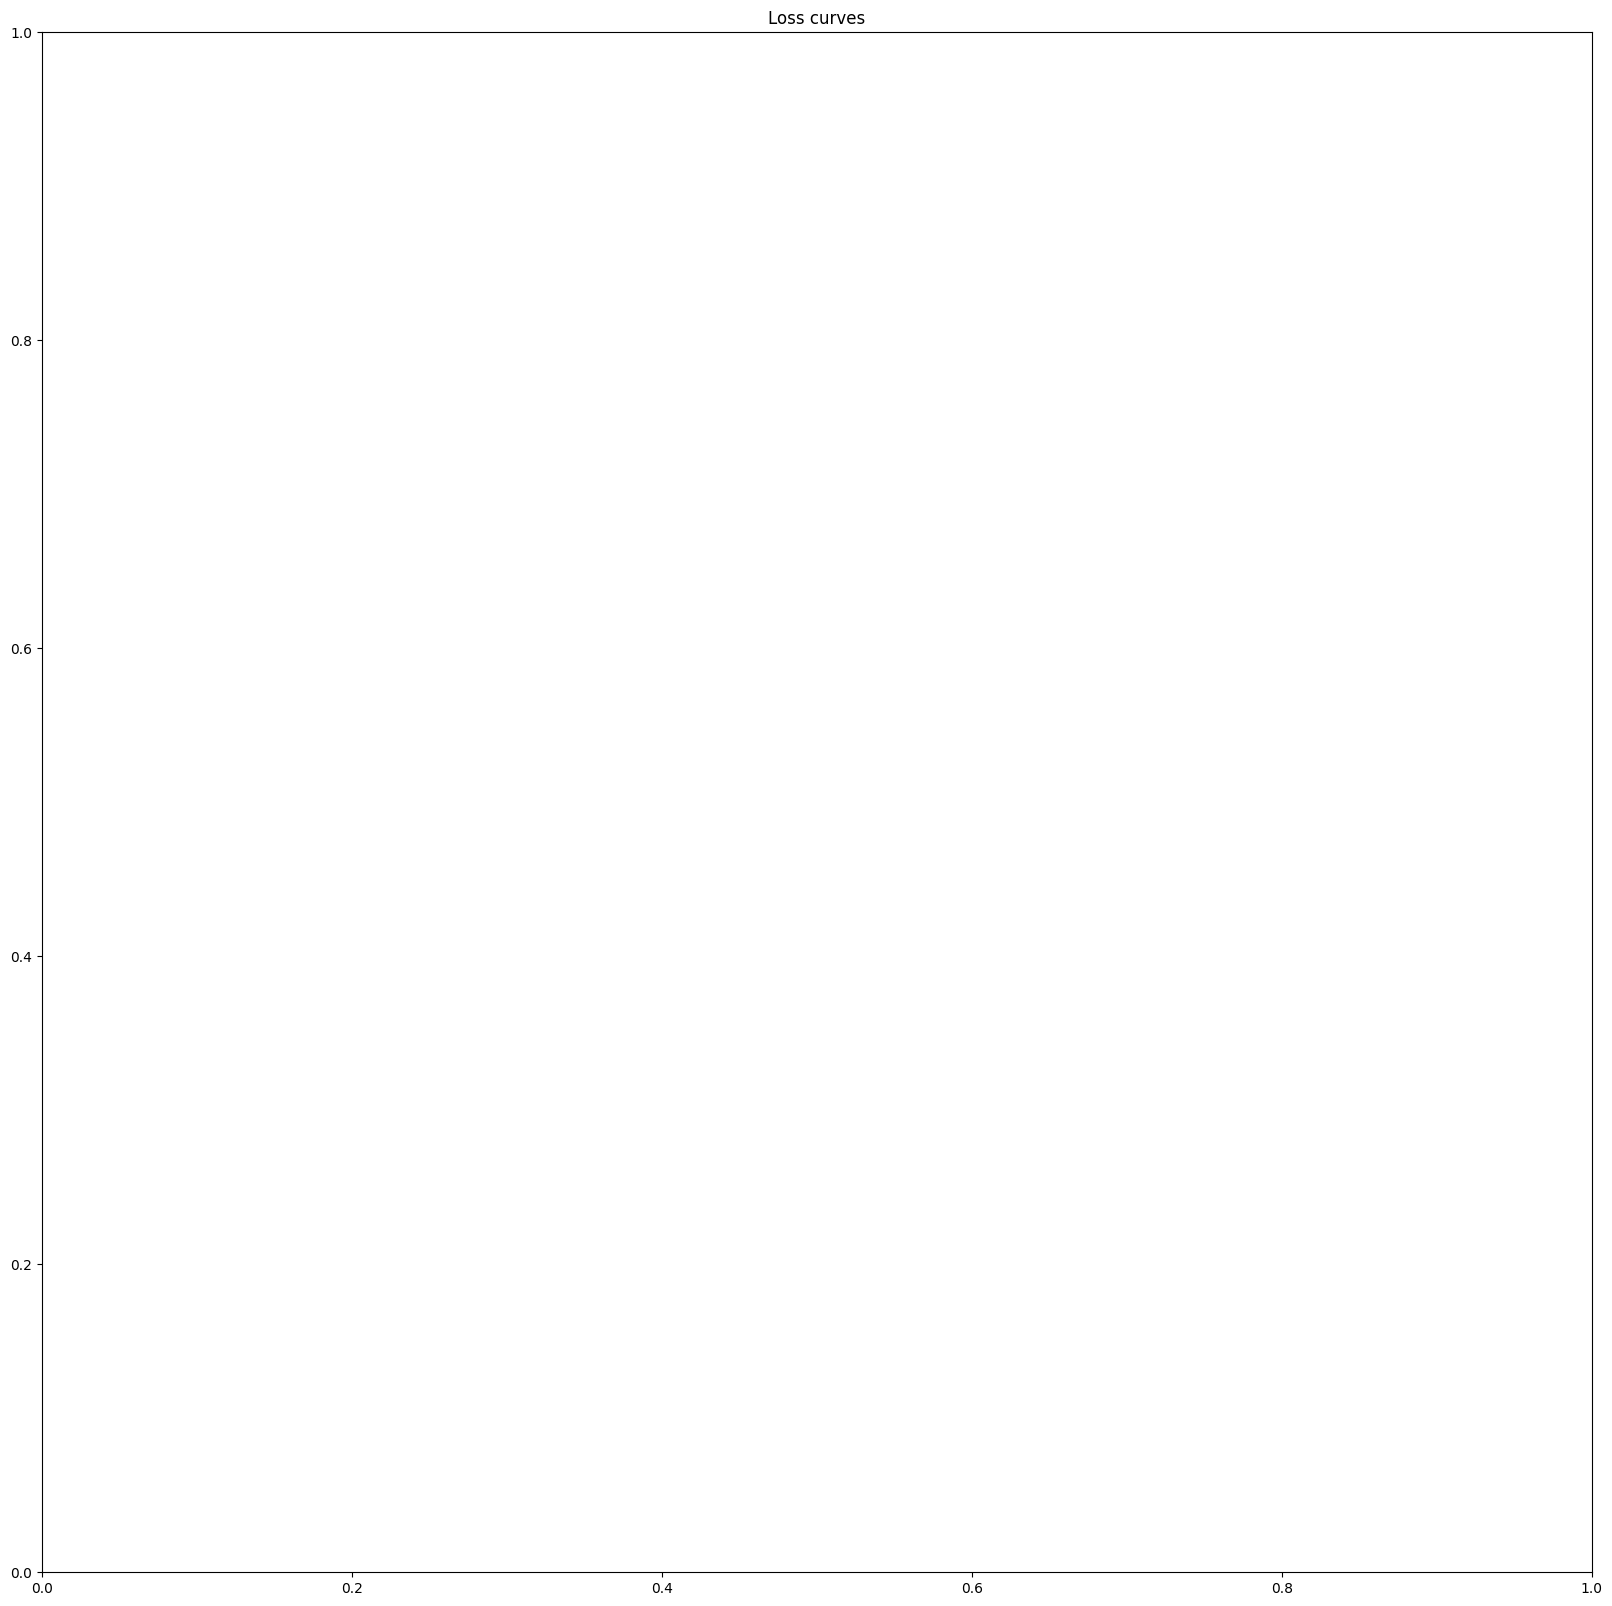

In [25]:
# Get predictions and true labels
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Generate a classification report
print(classification_report(true_classes, predicted_classes, target_names=class_names))

# Generate a confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

import matplotlib.pyplot as plt

# Assuming 'history' is the history object returned by model.fit()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.figure(figsize=(20,20))
plt.title('Loss curves')
plt.show()
